# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import joblib
from sklearn.metrics import roc_auc_score

In [5]:
import xgboost as xgb

In [1]:
from matplotlib import pyplot as plt
from xgboost import plot_importance

# Read

In [8]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
sample_submission = pd.read_csv('./sample_submission.csv')

In [9]:
train.head(1)

,Word,Label
0,Аалтонен,1


In [10]:
test.head(1)

,Word
0,Аалто


In [11]:
print('1:{}\n0:{}'.format(train[train['Label']==1].shape, train[train['Label']==0].shape))

1:(10638, 2)
0:(90770, 2)


In [12]:
print(train.shape, test.shape)

(101408, 2) (188920, 1)


In [13]:
# не фамилии и они есть =\
train.iloc[[1320, 1363, 1523]]

,Word,Label
1320,акт,1
1363,активисты,1
1523,алгоритмы,1


In [14]:
sample_submission.head(2)

,Id,Prediction
0,0,0
1,1,0


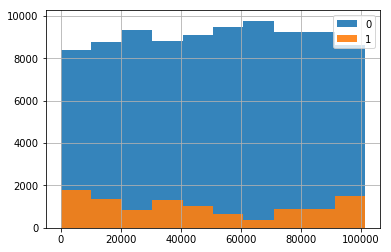

In [15]:
plt.hist(train[train['Label']==0].index, alpha=0.9, label='0')
plt.hist(train[train['Label']==1].index, alpha=0.9, label='1')
# plt.hist(rows_w_ss, alpha=0.3, label='ss')
plt.grid(True)
plt.legend(loc='upper right')

# XGB

## Encode

### Word features

In [16]:
def get_3_first(word):
    return word[:3].lower()

def get_3_last(word):
    return (word[-3:].lower())

def normalize_word(word):
    return (word[0] + word[1:].lower())

In [17]:
def fit_encoder(train, test):
    cols_w = set()
    exper_frame = pd.DataFrame({'Word': pd.concat([train['Word'], test['Word']], axis=0)})
    exper_frame['beg'] = exper_frame['Word'].apply(get_3_first)
    exper_frame['end'] = exper_frame['Word'].apply(get_3_last)
    for word in exper_frame['Word'].values:
        cols_w.update(set(word))
    cols_w.update(set(exper_frame['beg'].values))
    cols_w.update(set(exper_frame['end'].values))
    cols_w.update(set(map(str, range(0, 100))))
    cols_w_list = list(cols_w)
    cols_w_list.sort()
    print(len(cols_w_list), cols_w_list[:20])
    label_encoder_x = LabelEncoder()
    _ = label_encoder_x.fit(cols_w_list)
    return label_encoder_x

In [18]:
def label_encode_chars(frame, label_encoder_x):
    print("------LabelEncoder------")
    array_list = []
    matrix_x = frame.as_matrix()
    for itero in range(matrix_x.shape[1]):
        array_list.append(label_encoder_x.transform(matrix_x[:,itero].astype(str)))
    matr_enc_x = np.array(array_list).T
    print("------DONE------")
    return matr_enc_x

In [19]:
def words_to_features(frame):
    fr_copy = frame.copy()
    fr_copy['len'] = fr_copy['Word'].apply(lambda x: len(x))
    fr_copy['beg'] = fr_copy['Word'].apply(get_3_first)
    fr_copy['end'] = fr_copy['Word'].apply(get_3_last)
    fr_copy['Word'] = fr_copy['Word'].apply(normalize_word)
    chars_dicts_list = []
    lang_feat_list = []
    for index, row in fr_copy.iterrows():
        if (index % 1000) == 0: print(index, '\t', row['Word'])
        chars_dicts_list.append({k: v for k, v in enumerate(row['Word'])})
        lang_feat_list.append(lang_features(row['Word']))
    fr_copy = pd.concat([fr_copy, 
                         pd.DataFrame(lang_feat_list),
                         pd.DataFrame(chars_dicts_list)
                        ], axis=1)
    fr_copy = fr_copy.drop(['Word'], axis=1)
    if fr_copy.shape[1] < 49:
        for ite in range(31, 38):
            fr_copy[ite] = None
    fr_copy = fr_copy.fillna(0)
    return fr_copy

### lang features

In [235]:
def count_vow_consn(word):
    return {'vowels': sum(1 for x in word.lower() if x in 'аеёиоюэя'), 
            'consonants': sum(1 for x in word.lower() if x in 'бвгджзклмнпрстфхцчшщ')
           }
count_vow_consn('алгебра')

{'consonants': 4, 'vowels': 3}

In [236]:
def count_ship_swist(word):
    return {'ship': sum(1 for x in word.lower() if x in 'жчшщ'), 
            'swist': sum(1 for x in word.lower() if x in 'цзс')}
count_ship_swist('Арбуз')

{'ship': 0, 'swist': 1}

In [237]:
def count_parn_neparn(word):
    return {'zvon_parn': sum(1 for x in word.lower() if x in 'бвгджз'), 
            'zvon_neparn': sum(1 for x in word.lower() if x in 'лмнрй'), 
            'glukh_parn': sum(1 for x in word.lower() if x in 'пфктшс'), 
            'glukh_neparn': sum(1 for x in word.lower() if x in 'хцчщ')
           }
count_parn_neparn('Встреча')

{'glukh_neparn': 1, 'glukh_parn': 2, 'zvon_neparn': 1, 'zvon_parn': 1}

In [238]:
def count_up_low(word):
    return {'upper': sum(1 for x in word if x.isupper()), 
            'lower': sum(1 for x in word if x.islower())}
count_up_low('Встреча')

{'lower': 6, 'upper': 1}

In [239]:
def lang_features(word):
    return {**count_up_low(word), **count_vow_consn(word), **count_parn_neparn(word), **count_ship_swist(word)}
lang_features('Иванидзе')

{'consonants': 4,
 'glukh_neparn': 0,
 'glukh_parn': 0,
 'lower': 7,
 'ship': 0,
 'swist': 1,
 'upper': 1,
 'vowels': 4,
 'zvon_neparn': 1,
 'zvon_parn': 3}

## Fit/Pred

In [240]:
label_encoder_x = fit_encoder(train, test)

7999 [' ', ' ли', ' ст', ' тв', ' чу', ' эл', ' эс', '"', '&', "'", "'ши", '-', '-33', '-34', '-ва', '-ве', '-во', '-вр', '-де', '-жа']


In [241]:
encoded_y = train['Label'].as_matrix().reshape(train.shape[0],)

In [ ]:
chars_train = words_to_features(train.drop(['Label'], axis=1))
chars_test = words_to_features(test)

In [243]:
encoded_x = label_encode_chars(chars_train, label_encoder_x)
test_encoded_x = pd.DataFrame(label_encode_chars(chars_test, label_encoder_x), columns=chars_train.columns)

------LabelEncoder------
------DONE------
------LabelEncoder------
------DONE------


In [244]:
encoded_frame = pd.DataFrame(encoded_x, columns=chars_train.columns)
x_train,  x_valid, y_train, y_valid = train_test_split(encoded_frame, encoded_y, random_state=88)

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]

In [246]:
params = {'max_depth': 50, 
          'min_child_weight': 50, 
          'lambda': 0.1,
          'alpha': 0.05,
          'eta': 0.1, 
          'objective': 'binary:logistic',
          'eval_metric' : 'auc',
          'silent': 1,
          'seed': 898
         }
model1 = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=200, verbose_eval=10)

[0]	train-auc:0.863033	valid-auc:0.841368
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 200 rounds.
[10]	train-auc:0.888291	valid-auc:0.86405
[20]	train-auc:0.899181	valid-auc:0.875145
[30]	train-auc:0.906496	valid-auc:0.882887
[40]	train-auc:0.910634	valid-auc:0.886336
[50]	train-auc:0.915849	valid-auc:0.889989
[60]	train-auc:0.920237	valid-auc:0.892796
[70]	train-auc:0.924371	valid-auc:0.89411
[80]	train-auc:0.927867	valid-auc:0.895664
[90]	train-auc:0.931204	valid-auc:0.89685
[100]	train-auc:0.934159	valid-auc:0.898027
[110]	train-auc:0.936958	valid-auc:0.89876
[120]	train-auc:0.939327	valid-auc:0.899443
[130]	train-auc:0.941596	valid-auc:0.900108
[140]	train-auc:0.943688	valid-auc:0.900548
[150]	train-auc:0.945717	valid-auc:0.900976
[160]	train-auc:0.947651	valid-auc:0.901618
[170]	train-auc:0.949329	valid-auc:0.901845
[180]	train-auc:0.951	valid-auc:0.90212
[190]	train-auc:0.952474	valid-auc:0.90

In [247]:
d_train_full = xgb.DMatrix(encoded_frame, label=train['Label'])
print('AUC XgBoost: ', roc_auc_score(train['Label'], model1.predict(d_train_full)))

AUC XgBoost:  0.9749089017458227


In [195]:
d_test = xgb.DMatrix(test_encoded_x)
predictions = model1.predict(d_test)

In [196]:
submission = pd.DataFrame({'Id': test.index,
                           'Prediction': predictions })

In [197]:
submission.to_csv('./submission.baseline.chars.lang.beg.ends.lowered.csv', index=False)

## Model info

In [206]:
chars_train.describe()

,len,consonants,glukh_neparn,glukh_parn,lower,ship,swist,upper,vowels,zvon_neparn,zvon_parn,31,32,33,34,35,36,37
count,101408.000000,101408.000000,101408.000000,101408.000000,101408.000000,101408.000000,101408.000000,101408.000000,101408.000000,101408.000000,101408.000000,101408.0,101408.0,101408.0,101408.0,101408.0,101408.0,101408.0
mean,8.449107,4.699274,0.276359,1.615592,7.989389,0.214204,0.600357,0.450536,3.211887,1.908686,0.989281,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,2.871711,1.724211,0.498363,1.242660,3.006019,0.435955,0.722961,0.497550,1.453091,1.127448,0.934033,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,6.000000,3.000000,0.000000,1.000000,6.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,8.000000,5.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000,3.000000,2.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,10.000000,6.000000,1.000000,2.000000,10.000000,0.000000,1.000000,1.000000,4.000000,3.000000,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,31.000000,17.000000,4.000000,8.000000,30.000000,3.000000,4.000000,1.000000,11.000000,8.000000,6.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [205]:
chars_test.describe()

,len,consonants,glukh_neparn,glukh_parn,lower,ship,swist,upper,vowels,zvon_neparn,zvon_parn
count,188920.000000,188920.000000,188920.000000,188920.000000,188920.000000,188920.000000,188920.000000,188920.000000,188920.000000,188920.000000,188920.000000
mean,8.440054,4.686905,0.277186,1.610777,7.977477,0.213985,0.598063,0.451789,3.209819,1.906924,0.982543
std,2.880437,1.727405,0.497980,1.243657,3.016810,0.436283,0.724280,0.497672,1.457809,1.128380,0.932888
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,3.000000,0.000000,1.000000,6.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000
50%,8.000000,4.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000,3.000000,2.000000,1.000000
75%,10.000000,6.000000,1.000000,2.000000,10.000000,0.000000,1.000000,1.000000,4.000000,3.000000,2.000000
max,38.000000,20.000000,4.000000,8.000000,34.000000,3.000000,5.000000,1.000000,12.000000,12.000000,6.000000


In [248]:
def my_plot_importance(booster, figsize, **kwargs):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    return plot_importance(booster=booster, ax=ax, **kwargs)

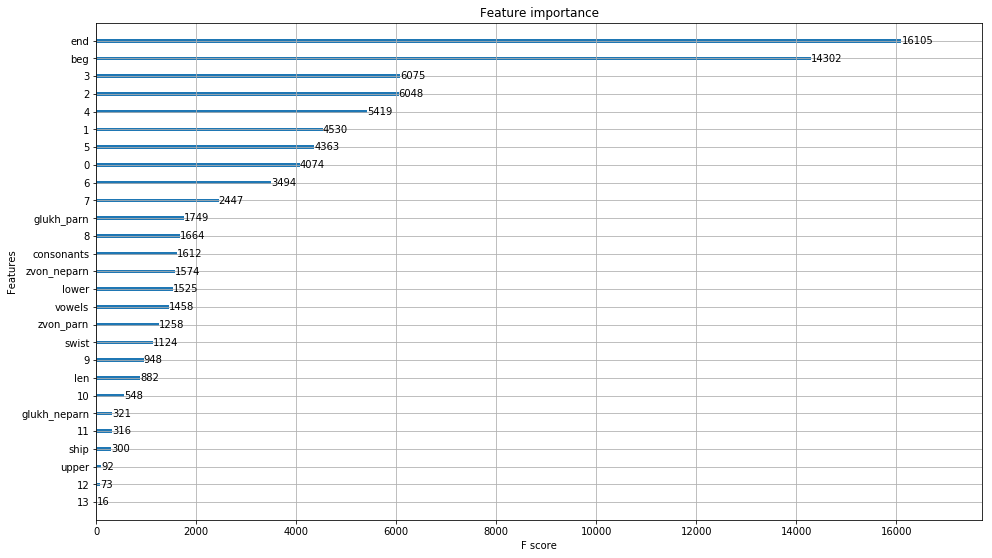

In [249]:
my_plot_importance(model1, (15, 10))

In [201]:
plt.rcParams.update({'figure.subplot.left':0.08,
                   'figure.figsize': (200, 200),
                   'figure.subplot.right': 0.9,
                   'figure.subplot.top': 0.94,
                   'figure.subplot.bottom': 0.25})

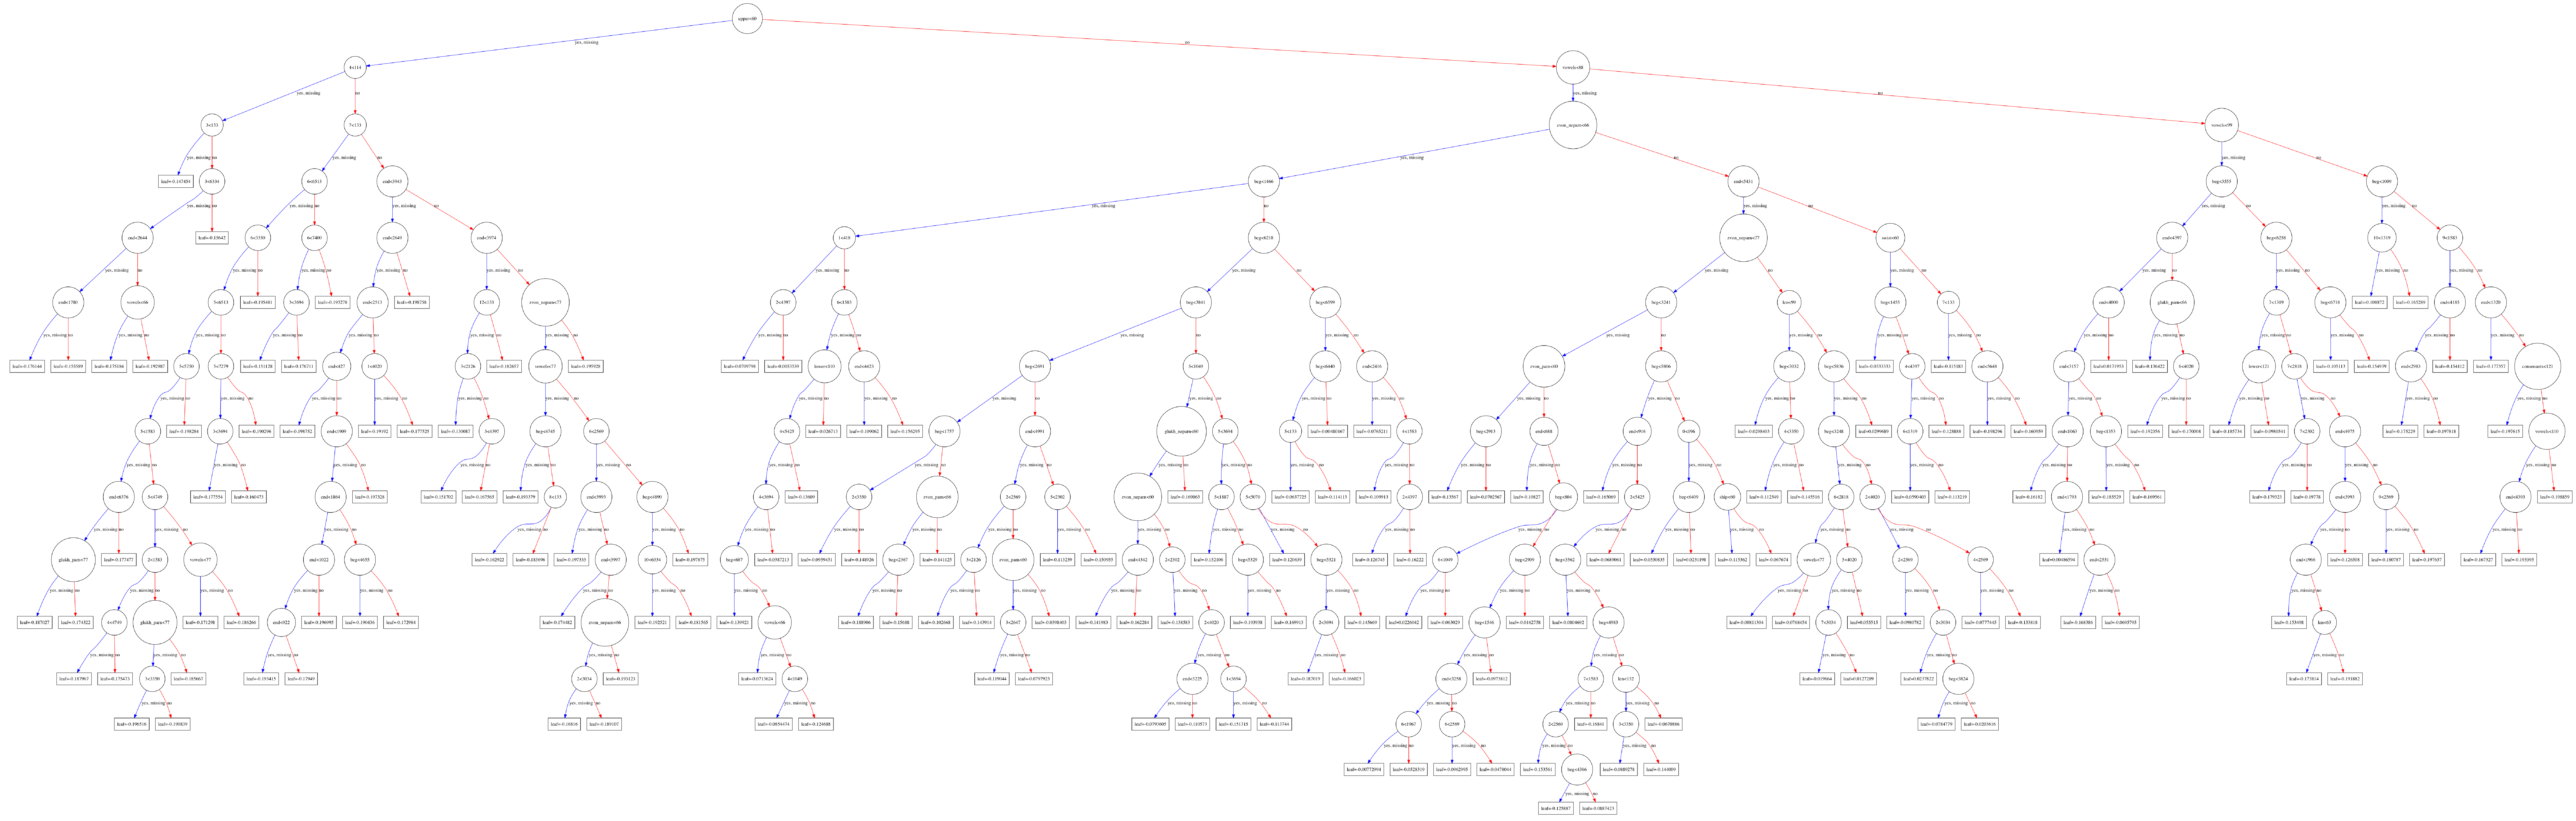

In [202]:
xgb.plot_tree(model1)

# Pymystem3

In [158]:
import pymystem3

In [176]:
mystem = pymystem3.Mystem()
res = mystem.analyze("О'Брайен")

In [177]:
res

[{'analysis': [{'gr': 'INTJ=', 'lex': 'о'}], 'text': 'О'},
 {'text': "'"},
 {'analysis': [{'gr': 'S,имя,муж,од=им,ед', 'lex': 'брайен'}],
  'text': 'Брайен'},
 {'text': '\n'}]

# Nltk

In [2]:
import nltk

In [180]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/solo/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [17]:
text = "to be or not to be"
words = nltk.word_tokenize(text)
my_bigrams = nltk.bigrams(words)
my_trigrams = nltk.trigrams(words)

In [18]:
print(list(my_bigrams), list(my_trigrams))

[('to', 'be'), ('be', 'or'), ('or', 'not'), ('not', 'to'), ('to', 'be')] [('to', 'be', 'or'), ('be', 'or', 'not'), ('or', 'not', 'to'), ('not', 'to', 'be')]
